In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional

In [2]:
class AuthState(TypedDict):
    username: Optional[str] 
    password: Optional[str]
    is_authenticated: Optional[bool]
    output: Optional[str]

In [3]:
auth_state_1: AuthState = {
    "username": "alice123",
    "password": "123",
    "is_authenticated": True,
    "output": "Login successful."
}
print(f"auth_state_1: {auth_state_1}")

auth_state_1: {'username': 'alice123', 'password': '123', 'is_authenticated': True, 'output': 'Login successful.'}


In [4]:
auth_state_2: AuthState = {
    "username":"",
    "password": "wrongpassword",
    "is_authenticated": False,
    "output": "Authentication failed. Please try again."
}
print(f"auth_state_2: {auth_state_2}")

auth_state_2: {'username': '', 'password': 'wrongpassword', 'is_authenticated': False, 'output': 'Authentication failed. Please try again.'}


Nodes: 
- input_node (get username if it's not defined and password) -> this is the entry point.
- validate_credentials_node (check if username and password are correct - fill "is_authenticated" property)
- router_node (depending of "is_authenticated" the wf continue with "sucess" or with "failure" node)
- success_node (Just print that the authentication was sucessfull)
- failure_node (print that the authentication failed, try again)

Edges:
- from input to validate_credential
- from success to END
- from failure to input (try again)
- conditional, depending of "router" from "validate_credential" to "success" or to "failure"

Defining the nodes:


In [5]:
def input_node(state: AuthState) -> AuthState:
    # check if username exist, if not, ask for it to the user
    if state.get("username", None) is None:
        state["username"] = input("Enter your username: ")

    password = input("Enter your password: ")

    # Return updated state with new password
    return {"password": password}


def validate_credentials(state: AuthState) -> AuthState:
    # Simulate credential validation
    username = state.get("username", None)
    password = state.get("password", None)

    print(f"Validating credentials for user: {username}")
    print(f"Password provided: {password}")

    if username == "isa" and password == "secure_password123":
        is_authenticated = True
    else:
        is_authenticated = False

    # Return the updated state with authentication result
    return {"is_authenticated": is_authenticated}


def sucess_node(state: AuthState) -> str:
    print("Login successful. Olé!")
    return {"output": "Login successful. Olé!"}


def failure_node(state: AuthState) -> str:
    print("Authentication failed. Please try again.")
    return {"output": "Authentication failed. Please try again."}


def router_node(state: AuthState) -> str:
    if state.get("is_authenticated", None):
        return "go_to_success_node"
    else:
        return "go_to_failure_node"

In [6]:
# some tests to understand the node behavior
# print(input_node(auth_state_1))
# validate_credentials(auth_state_1)
# router_node(auth_state_1)

In [7]:
# Create an instance of StateGraph with the GraphState structure
wf = StateGraph(AuthState)

wf.add_node("Input", input_node)
wf.add_node("Validate", validate_credentials)
wf.add_node("Success", sucess_node)
wf.add_node("Failure", failure_node)

Let's define the edges now

In [8]:
wf.add_edge("Input", "Validate")
wf.add_edge("Success", END)
wf.add_edge("Failure", "Input")
wf.add_conditional_edges("Validate",
                         router_node, {
                             "go_to_success_node": "Success",
                             "go_to_failure_node": "Failure"
                         })

In [9]:
wf.set_entry_point("Input")
app = wf.compile()

In [10]:

inputs = {"username": "isa"}
result = app.invoke(inputs)
print(result)
print(result['output'])

Validating credentials for user: isa
Password provided: secure_password123
Login successful. Olé!
{'username': 'isa', 'password': 'secure_password123', 'is_authenticated': True, 'output': 'Login successful. Olé!'}
Login successful. Olé!


In [11]:
# %pip install grandalf

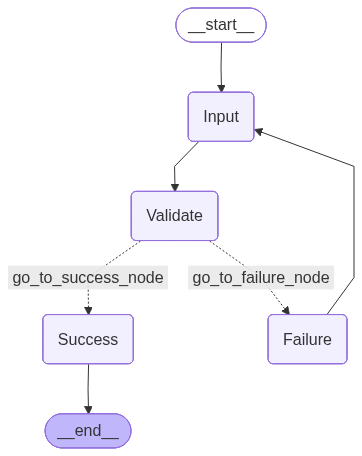

In [12]:
# Create a visual graph using grandalf

# Use LangGraph's built-in visualization with grandalf
from IPython.display import Image, display

# Get the graph visualization using grandalf
img = app.get_graph().draw_mermaid_png()
display(Image(img))


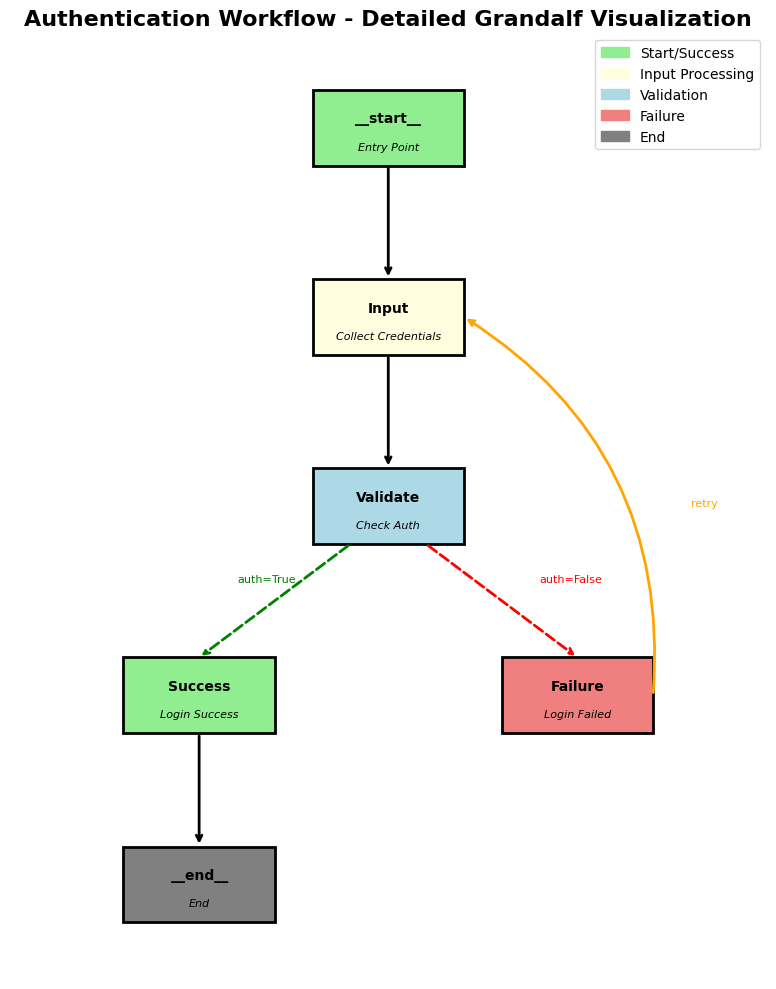

Detailed grandalf-based workflow visualization completed!
\nCredentials for successful authentication:
- Username: 'isa'
- Password: 'secure_password123'


In [13]:
# Let's also create a more detailed grandalf visualization with custom layout
from grandalf.layouts import SugiyamaLayout
from grandalf.graphs import Vertex, Edge, Graph
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a more detailed visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Define node positions manually for better clarity
node_positions = {
    '__start__': (200, 400),
    'Input': (200, 300),
    'Validate': (200, 200),
    'Success': (100, 100),
    'Failure': (300, 100),
    '__end__': (100, 0)
}

# Define node colors and descriptions
node_info = {
    '__start__': {'color': 'lightgreen', 'desc': 'Entry Point'},
    'Input': {'color': 'lightyellow', 'desc': 'Collect Credentials'},
    'Validate': {'color': 'lightblue', 'desc': 'Check Auth'},
    'Success': {'color': 'lightgreen', 'desc': 'Login Success'},
    'Failure': {'color': 'lightcoral', 'desc': 'Login Failed'},
    '__end__': {'color': 'gray', 'desc': 'End'}
}

# Draw nodes
for node, (x, y) in node_positions.items():
    info = node_info[node]
    rect = patches.Rectangle((x-40, y-20), 80, 40, 
                           linewidth=2, edgecolor='black', 
                           facecolor=info['color'])
    ax.add_patch(rect)
    ax.text(x, y+5, node, ha='center', va='center', 
            fontsize=10, fontweight='bold')
    ax.text(x, y-10, info['desc'], ha='center', va='center', 
            fontsize=8, style='italic')

# Draw edges with labels
graph = app.get_graph()
edge_info = []

for edge in graph.edges:
    if edge.source in node_positions and edge.target in node_positions:
        x1, y1 = node_positions[edge.source]
        x2, y2 = node_positions[edge.target]
        
        if edge.conditional:
            # Conditional edges (dashed)
            if edge.data == 'go_to_success_node':
                ax.annotate('', xy=(x2, y2+20), xytext=(x1-20, y1-20),
                           arrowprops=dict(arrowstyle='->', lw=2, color='green', linestyle='--'))
                ax.text((x1+x2)/2-30, (y1+y2)/2+10, 'auth=True', fontsize=8, color='green')
            elif edge.data == 'go_to_failure_node':
                ax.annotate('', xy=(x2, y2+20), xytext=(x1+20, y1-20),
                           arrowprops=dict(arrowstyle='->', lw=2, color='red', linestyle='--'))
                ax.text((x1+x2)/2+30, (y1+y2)/2+10, 'auth=False', fontsize=8, color='red')
        else:
            # Regular edges (solid)
            if edge.source == 'Failure' and edge.target == 'Input':
                # Retry loop - curved arrow
                ax.annotate('', xy=(x2+40, y2), xytext=(x1+40, y1),
                           arrowprops=dict(arrowstyle='->', lw=2, color='orange',
                                         connectionstyle="arc3,rad=0.3"))
                ax.text(x1+60, (y1+y2)/2, 'retry', fontsize=8, color='orange')
            else:
                ax.annotate('', xy=(x2, y2+20), xytext=(x1, y1-20),
                           arrowprops=dict(arrowstyle='->', lw=2, color='black'))

ax.set_xlim(0, 400)
ax.set_ylim(-50, 450)
ax.set_aspect('equal')
ax.set_title('Authentication Workflow - Detailed Grandalf Visualization', 
             fontsize=16, fontweight='bold')
ax.axis('off')

# Add legend
legend_elements = [
    patches.Patch(color='lightgreen', label='Start/Success'),
    patches.Patch(color='lightyellow', label='Input Processing'),
    patches.Patch(color='lightblue', label='Validation'),
    patches.Patch(color='lightcoral', label='Failure'),
    patches.Patch(color='gray', label='End')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print("Detailed grandalf-based workflow visualization completed!")
print("\\nCredentials for successful authentication:")
print("- Username: 'isa'")
print("- Password: 'secure_password123'")